## Portuguese Word Embeddings Demo
#### In this notebook we will demonstrate some interesting features of word embeddings.

First we will load everything we will need:

In [1]:
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

In here we load the embedding. Those were pretrained by NILC on a large corpora of brazilian and european portuguese.
[Download here](http://www.nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc).

In [2]:
emb = "./models/glove_s300.txt"
model = KeyedVectors.load_word2vec_format(emb, binary=False, unicode_errors="ignore")

Then we can apply [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) on some points of the vocabulary words to reduce their dimensions from 300 to 2, so that we can plot them and see how similar they are to each other. The closer the words, the more similar they are.

In [3]:
def plot(model, num_points):
    labels = []
    tokens = []
    points = 0

    for word in model.wv.vocab:
        if points > num_points:
            break
        tokens.append(model[word])
        labels.append(word)
        points += 1
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    twod_embedding = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in twod_embedding:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

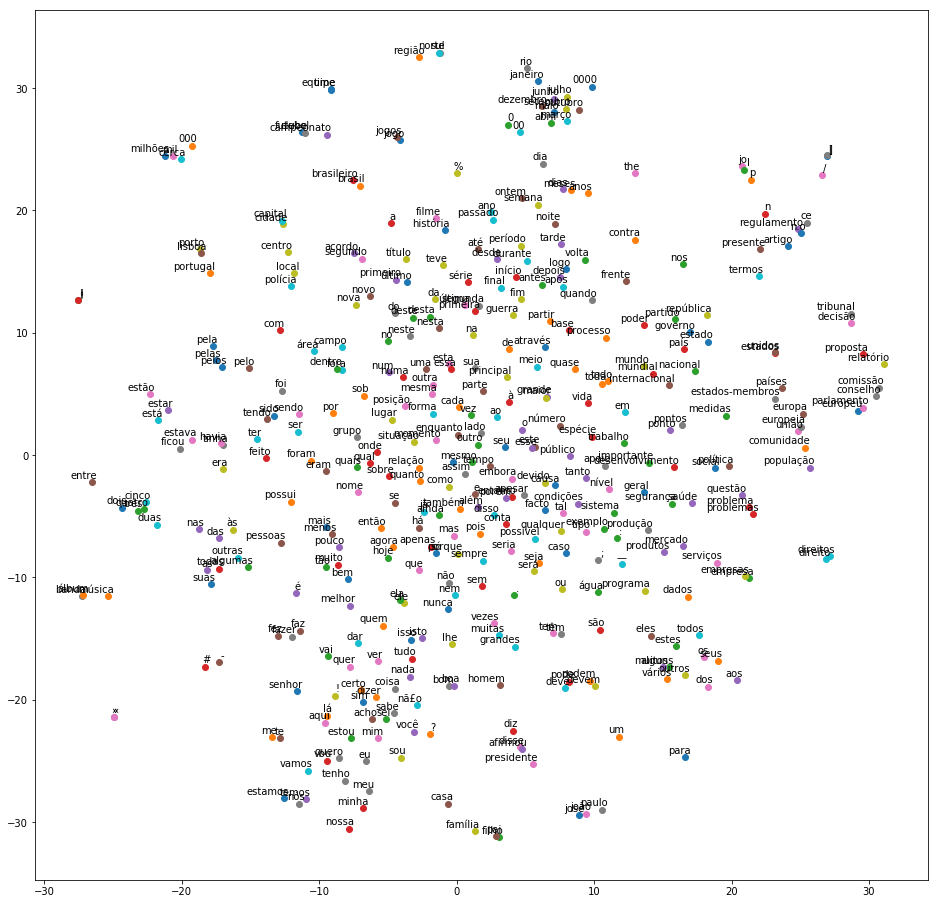

In [4]:
plot(model, 400)

We can also directly check the most similar words to a given one:

In [5]:
model.most_similar("acórdão")

[('recorrido', 0.6369601488113403),
 ('acórdãos', 0.6242930889129639),
 ('tribunal', 0.6157128810882568),
 ('proferido', 0.6099216938018799),
 ('jurisprudência', 0.5954267382621765),
 ('instância', 0.5901838541030884),
 ('despacho', 0.5428516864776611),
 ('c-000', 0.5419331789016724),
 ('anulação', 0.5203611850738525),
 ('impugnado', 0.5195749998092651)]

In [6]:
model.most_similar("pai")

[('filho', 0.8212587833404541),
 ('irmão', 0.8047417402267456),
 ('mãe', 0.7788839936256409),
 ('marido', 0.7483679056167603),
 ('avô', 0.7426179647445679),
 ('filha', 0.7172733545303345),
 ('tio', 0.7169166803359985),
 ('amigo', 0.7160125970840454),
 ('esposa', 0.6812863945960999),
 ('filhos', 0.6757663488388062)]

One cool thing word embeddings do is to encode in vectorial space semantic properties. For example, we can get representations for gender:

In [7]:
def plot_gender(model, num_points=400):
    gender_words = ["avô", "tio", "pai", "irmão", "filho", "avó", "tia", "mãe", "irmã", "filha"]
    labels = []
    tokens = []
    points = 0

    for word in model.wv.vocab:
        if points > num_points:
            break
        tokens.append(model[word])
        labels.append(word)
        points += 1
        
    for word in gender_words:
        if word not in labels:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    twod_embedding = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in twod_embedding:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(5, 5)) 
    for i in range(len(x)):
        if labels[i] in gender_words:
            plt.scatter(x[i],y[i])
            plt.annotate(labels[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
    plt.show()

Note that from male to female words there is the same general direction. The same is true for the relationship before capital cities and their country:

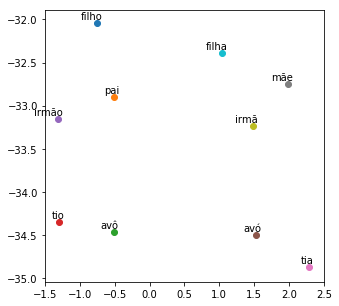

In [8]:
plot_gender(model)

Another thing that is possible to do with word embeddings is word analogies. For example, to "man is to woman, as king is to *blank*" we expect the answer "queen".

In [9]:
def analogy(model, a, b, c):
    d = model[c] - model[a] + model[b]
    
    return [x for x in model.similar_by_vector(d) if x[0] not in [a, b, c]][0]

In [10]:
analogy(model, "pai", "mãe", "filho")

('filha', 0.808993935585022)

In [11]:
analogy(model, "japão", "tóquio", "inglaterra")

('londres', 0.719485878944397)

In [12]:
analogy(model, "homem", "mulher", "rei")

('rainha', 0.7281292676925659)

In [13]:
analogy(model, "sol", "manhã", "lua")

('noite', 0.5799813866615295)

Finally, we can implement a simple function that takes as input the model, a male word, and a vector that "encodes gender", and return the female word that corresponds to the male word.

In [14]:
def make_female(model, male_word, gender):
    female_word_vector = model[male_word] - gender
    return [x for x in model.similar_by_vector(female_word_vector) if x[0] != male_word][0]
    

To encode the notion of gender in a vector one can subtract from many male word embeddings their female counterpart and then get the mean of the difference.

In [15]:
male_vectors = np.array([model["homem"], model["pai"], model["filho"], model["vô"], model["irmão"]])
female_vectors = np.array([model["mulher"], model["mãe"], model["filha"], model["vó"], model["irmã"]])
gender = np.mean(male_vectors - female_vectors, axis=0)

In [16]:
make_female(model, "homem", gender)

('mulher', 0.8453143239021301)

In [17]:
make_female(model, "rei", gender)

('rainha', 0.7707790732383728)

In [18]:
make_female(model, "menino", gender)

('menina', 0.7949270009994507)